# Embedded systems connection

This file serves as the main tool to connect the Python simulation as found in simulation.ipynb to the STM32 Nucleo board (MCU). Throughout this file, the simulation will gradually be converted to the MCU, and serial messages will be exchanged between the PC and MCU. Dummy data files from ephemeris retrieval will be used at first.

### Import packages

In [33]:
import numpy as np
import scipy as sc
import os
import re
from scipy.integrate import RK45
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from astroquery.jplhorizons import Horizons
import datetime
import sys
import control as c
import serial as s
import classes as cl
from astropy.time import Time
import cvxpy as cp
import serial.tools.list_ports
import time
import struct

### Helper functions

In [34]:
def list_serial_ports():
    ports = serial.tools.list_ports.comports()
    connected = []
    for port, desc, hwid in sorted(ports):
        print(f"{port}: {desc} [hwid: {hwid}]")
        connected.append(port)
    return connected


def send_parameters(pos_CAP, pos_Sun, q, omega, k_p, k_i, k_d, k_s, dt):
    ser.reset_input_buffer()
    ser.reset_output_buffer()
    # Create a single string from all parameters
    data_string = ','.join(map(str, np.concatenate((pos_CAP, pos_Sun, q, omega, k_p, k_i, k_d, k_s, [dt])))) + '\n'
    print("Data string is ", data_string)
    ser.write(data_string.encode())  # Send the concatenated string over the serial connection
    print("Send successful")


def string_to_float_array(input_string):
    # Split the string into components based on commas
    string_components = input_string.split(',')
    # Convert each string component to a float and store it in an array
    float_array = [float(value) for value in string_components]
    
    return float_array


### Initialize serial connection

### Simulation - Base case (no MCU connection)

In [35]:
def simulation_base(
    data_file_CAPSTONE,
    data_file_Sun,
    omega_0,
    kp,
    kd,
    ks,
    T_matrix
):
    # Load data files
    data_CAPSTONE = np.loadtxt(data_file_CAPSTONE)
    data_Sun = np.loadtxt(data_file_Sun)

    # Create time array based on the input data files and check if they cover the same epochs
    time_array = data_CAPSTONE[:, 0]
    time_array_check = data_Sun[:, 0]
    if time_array.all() != time_array_check.all():
        raise ValueError(
            "Epochs of the data files are not the same; check ephemeris retrieval."
        )
    
    # Initialize storage arrays for visualization
    q_ref_vis = np.empty((4, len(time_array)))
    q_vis = np.empty((4, len(time_array)))
    
    # Empty iteration time array
    it = np.empty((1, len(time_array)))

    # Obtain position data over time
    position_CAPSTONE = data_CAPSTONE[:, 1:4]
    position_Sun = data_Sun[:, 1:4]

    # Retrieve time step from data file
    dt = time_array[1] - time_array[0]

    const = cl.Constants()
    pd = cl.PID(const.inertia_matrix_undeployed)
    dist = cl.DisturbanceTorques(const.inertia_matrix_undeployed)
    vis = cl.Visualization(time_array)

    # Initialize individual vectors for iteration
    q = pd.reference_quaternion_paper(position_CAPSTONE[0,:], position_Sun[0,:]) # For standard initial position
    omega = omega_0

    # Dummy values for PID
    factor_p = kp
    factor_i = 0
    factor_d = kd
    factor_s = ks

    # Create arrays
    k_p = np.array([1, 1, 1]) * factor_p
    k_i = np.array([1, 1, 1]) * factor_i
    k_d = np.array([1, 1, 1]) * factor_d
    k_s = np.array([1, 1, 1]) * factor_s


    # Index count
    index = 0

    # Initiate angular momentum
    h = 0
    E_RW = 0
    E_thrust = 0

    for t in time_array:

        start = time.time()

        # LUMIO paper-based reference quaternion update
        if index % 1 == 0:
            q_ref = pd.reference_quaternion_paper(position_CAPSTONE[index,:], position_Sun[index,:])

        # Calculate real-time disturbance torques
        T_GG = dist.GGMoon(q, position_CAPSTONE[index, :])
        T_SRP = dist.SRP(position_Sun[index, :], position_CAPSTONE[index, :])
        T_d = T_GG + T_SRP

        # Control torque
        T_c = pd.control_torque(q, q_ref, omega, k_p, k_i, k_d, k_s, dt)

        # Update to t = 1
        # Integrate omega and quaternion
        omega_new = pd.rk4_integrator(pd.derivative_omega, omega, dt, T_d, T_c)
        q_new = pd.rk4_integrator(pd.derivative_quaternion, q, dt, omega)
        q = q_new / np.linalg.norm(q_new)
        omega = omega_new

        q_ref_vis[:, index] = q_ref
        q_vis[:, index] = q

        end = time.time()

        it[:,index - 1] = end - start


        # Update index
        index += 1
        
    # vis.euler_versus_time(q_ref_vis, q_vis)

    return q_vis

### Simulation - Serialised values, PD
In this  block of code, more functionalities are gradually transferred to MCU. \
Whenever this happens, the original Python function will still remain present under variable "..._test" name. \
In this way, easy reconfiguring to Python-only simulation can be done.

In [150]:
def simulation_embedded_PD(
    data_file_CAPSTONE,
    data_file_Sun,
    omega_0,
    kp,
    kd,
    ks,
    T_matrix
):

    try:
        # Load data files
        data_CAPSTONE = np.loadtxt(data_file_CAPSTONE)
        data_Sun = np.loadtxt(data_file_Sun)

        # Create time array based on the input data files and check if they cover the same epochs
        time_array = data_CAPSTONE[:, 0]
        time_array_check = data_Sun[:, 0]
        if time_array.all() != time_array_check.all():
            raise ValueError(
                "Epochs of the data files are not the same; check ephemeris retrieval."
            )
        
        # Extract metadata from data_file_CAPSTONE filename using regular expressions
        # Looks for date and time in the format YYYY-MM-DD HH:MM
        filename = os.path.basename(data_file_CAPSTONE)
        datetime_matches = re.findall(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}', filename)

        if len(datetime_matches) >= 2:
            startdate = datetime_matches[0].replace(":", "-").replace(" ", "_")
            enddate = datetime_matches[1].replace(":", "-").replace(" ", "_")
        else:
            raise ValueError("Could not extract start and end date-times from the filename.")
        
        # Define save directory
        save_dir = "/Users/Pieter/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Research Phase/lunar_CubeSat/results/data"
        os.makedirs(save_dir, exist_ok=True)

        # Empty iteration time array
        time_iteration = np.empty((1, len(time_array)))
        time_mcu = np.empty((1, len(time_array)))

        # Initialize storage arrays for visualization
        q_ref_vis = np.empty((4, len(time_array)))
        q_ref_mcu_vis = np.empty((4, len(time_array)))
        q_vis = np.empty((4, len(time_array)))
        T_c_vis = np.empty((3, len(time_array)))
        duty_cycle_vis = np.empty([6, len(time_array)])  # 6 rows for 6 thrusters
        thrust_vis = np.empty([6, len(time_array)])

        # Obtain position data over time
        position_CAPSTONE = data_CAPSTONE[:, 1:4]
        position_Sun = data_Sun[:, 1:4]

        # Retrieve time step from data file
        dt = float(time_array[1] - time_array[0])

        const = cl.Constants()
        pd = cl.PID(const.inertia_matrix)
        dist = cl.DisturbanceTorques(const.inertia_matrix)
        vis = cl.Visualization(time_array)

        # Initialize individual vectors for iteration
        q = pd.reference_quaternion_paper(position_CAPSTONE[0,:], position_Sun[0,:]) # For standard initial position

        omega = omega_0
        omega_test = omega_0

        # Dummy values for PID
        factor_p = kp
        factor_i = 0
        factor_d = kd
        factor_s = ks

        # Create arrays
        k_p = np.array([1, 1, 1]) * factor_p
        k_i = np.array([1, 1, 1]) * factor_i
        k_d = np.array([1, 1, 1]) * factor_d
        k_s = np.array([1, 1, 1]) * factor_s

        # Index count
        index = 0
        previous_q_ref = None

        for t in time_array:
            # Start iteration loop timer
            start = time.time()

            # Calculate real-time disturbance torques
            T_SRP = dist.SRP_deployed(q, position_Sun[index, :], position_CAPSTONE[index, :])
            T_GG = dist.GGMoon(q, position_CAPSTONE[index,:])

            # Start MCU connection timer
            mcu_start = time.time()
            send_parameters(position_CAPSTONE[index,:], position_Sun[index,:], q, omega, k_p, k_i, k_d, k_s, dt)

            # LUMIO paper-based reference quaternion update
            q_ref = pd.reference_quaternion_paper(position_CAPSTONE[index,:], position_Sun[index,:])

            # Check quaternion continuity; do we need to flip signs?
            if previous_q_ref is not None:
                if np.dot(q_ref, previous_q_ref) < 0:
                    q_ref = -q_ref
            
            # Store q_ref for next iteration
            previous_q_ref = q_ref

            T_c = pd.control_torque(q, q_ref, omega, k_p, k_i, k_d, k_s, dt)

            while True:
                q_ref_line = ser.readline().decode().strip()
                if q_ref_line:
                    q_ref_mcu = string_to_float_array(q_ref_line)
                    print("Qref Python is ", q_ref)
                    print("Qref MCU is ", q_ref_mcu)
                    break

            while True:
                T_c_mcu_line = ser.readline().decode().strip()
                if T_c_mcu_line:
                    T_c_mcu = string_to_float_array(T_c_mcu_line)
                    print("PD control torque is:", T_c)
                    print("MCU ontrol torque is:", T_c_mcu)
                    break
            
            # Loop through all 6 thrusters to retrieve duty cycles
            for thruster_idx in range(6):
                while True:
                    duty_cycle_line = ser.readline().decode().strip()
                    if duty_cycle_line:
                        duty_cycle = string_to_float_array(duty_cycle_line)
                        
                        # Check if the parsed array has at least one value
                        if len(duty_cycle) > 0:
                            duty_cycle_vis[thruster_idx, index] = duty_cycle[1]  # Assign safely
                        else:
                            print(f"Warning: Received empty duty cycle for Thruster {thruster_idx+1}. Defaulting to 0.")
                            duty_cycle_vis[thruster_idx, index] = 0  # Default value if no data
                            
                        break

            while True:
                thrust_line = ser.readline().decode().strip()
                if thrust_line:
                    thrust = string_to_float_array(thrust_line)
                    thrust_vis[:, index] = thrust[:6]  # Assuming all 6 thruster values are retrieved
                    break
            
            mcu_end = time.time()

            # Construct total disturbance torque
            T_d = T_GG + T_SRP

            # Update to t = 1
            # Integrate omega and quaternion
            omega_new = pd.rk4_integrator(pd.derivative_omega, omega, dt, T_d, T_c)
            q_new = pd.rk4_integrator(pd.derivative_quaternion, q, dt, omega)
            q = q_new / np.linalg.norm(q_new)
            omega = omega_new

            end = time.time()

            q_vis[:, index] = q
            T_c_vis[:, index] = T_c
            time_iteration[:, index] = end - start
            time_mcu[:, index] = mcu_end - mcu_start

            # Update index
            index += 1
            print(index)

            # Define the arrays to save
            embedded_vis_arrays = {
                "thrust_vis": thrust_vis,
                "duty_cycle_vis": duty_cycle_vis
            }

            # Loop through each array and save to file
            for var_name, data in embedded_vis_arrays.items():
                file_name = f"embedded_restofthename_{startdate}_{enddate}_{var_name}.dat"
                file_path = os.path.join(save_dir, file_name)
                np.savetxt(file_path, data.T, delimiter=" ", fmt="%.20f")  # Transpose for column format

        print("The average time for one iteration is ", np.mean(time_iteration))
        print("The average time for MCU calculation and retrieval by Python is ", np.mean(time_mcu))
        
        return thrust_vis, duty_cycle_vis

    finally:
        # Close the serial connection even if an exception occurs
        ser.close()
        print("Serial connection closed")


### Initiation

In [151]:
# Set-up 1
tau_11 = np.cross(np.array([0.1, 0.15, 0]), np.array([-1,0,0]))
tau_12 = np.cross(np.array([-0.1, 0.15, 0]), np.array([1,0,0]))
tau_13 = np.cross(np.array([0, 0.15, 0.1]), np.array([0,0,-1]))
tau_14 = np.cross(np.array([0, -0.15, 0.1]), np.array([0,0,-1]))
tau_15 = np.cross(np.array([0.1, 0, 0.1]), np.array([-1,0,0]))
tau_16 = np.cross(np.array([-0.1, 0, 0.1]), np.array([1,0,0]))

T_matrix_1 = np.column_stack((tau_11, tau_12, tau_13, tau_14, tau_15, tau_16))

# Angular velocity
omega_0 = np.array([0,0,0])

# Scale factor to make sure NaN is not reached
factor = 0.5

# Including the reference omega, not working
# kp = 5e-4
# kd = 1e-3
# ks = 9

kp = 5e-2
kd = 5e-2
ks = 12

In [159]:
# Configure the serial connections (the parameters differ on the device you are connecting to)
# Replace '/dev/ttyUSB0' with your serial port and 115200 with your baud rate
ser = s.Serial(
    port='/dev/cu.usbmodem11403',
    baudrate=115200,
    parity=s.PARITY_EVEN,
    stopbits=s.STOPBITS_ONE,
    bytesize=s.SEVENBITS,
    timeout=1
)

### Simulation x Embedded

In [160]:
# res_base = simulation_base(
# "converted_ephemeris_data/converted_1s_cartesian_coordinates_CAPSTONE_Moon-centered_2023-01-05 08:15_to_2023-01-05 08:30_1m.dat",
# "converted_ephemeris_data/converted_1s_cartesian_coordinates_Sun_Moon-centered_2023-01-05 08:15_to_2023-01-05 08:30_1m.dat",
# omega_0,
# kp,
# kd,
# ks,
# T_matrix_1)


timer, duty_cycle = simulation_embedded_PD(
"converted_ephemeris_data/converted_1s_cartesian_coordinates_CAPSTONE_Moon-centered_2023-01-01 00:00_to_2023-01-01 00:05_1m.dat",
"converted_ephemeris_data/converted_1s_cartesian_coordinates_Sun_Moon-centered_2023-01-01 00:00_to_2023-01-01 00:05_1m.dat",
omega_0,
kp,
kd,
ks,
T_matrix_1)




Data string is  270347.41889953165,20112288.821284488,-63209675.46335539,25144445920.38248,-145097327512.98172,12231368.554390969,0.07421054945043105,-0.05174984038269508,0.8037998387915837,-0.5879800740920179,0.0,0.0,0.0,0.05,0.05,0.05,0.0,0.0,0.0,0.05,0.05,0.05,12.0,12.0,12.0,1.0

Send successful
Qref Python is  [ 0.07421055 -0.05174984  0.80379984 -0.58798007]
Qref MCU is  [0.07421054945043105, -0.05174984038269508, 0.8037998387915837, -0.5879800740920179]
PD control torque is: [ 0.00000000e+00 -1.10804647e-18  0.00000000e+00]
MCU ontrol torque is: [7.8e-19, 0.0, 0.0]
1
Data string is  270380.17867679213,20112254.128014784,-63209807.24290676,25144476241.60508,-145097323098.43106,12231281.443797924,0.07421054945043105,-0.05174984038269508,0.8037998387915837,-0.5879800740920179,6.1399017290183816e-21,-4.748405534594054e-18,3.275129624432452e-20,0.05,0.05,0.05,0.0,0.0,0.0,0.05,0.05,0.05,12.0,12.0,12.0,1.0

Send successful
Qref Python is  [ 0.07421078 -0.05174977  0.80379949 -0.58798053

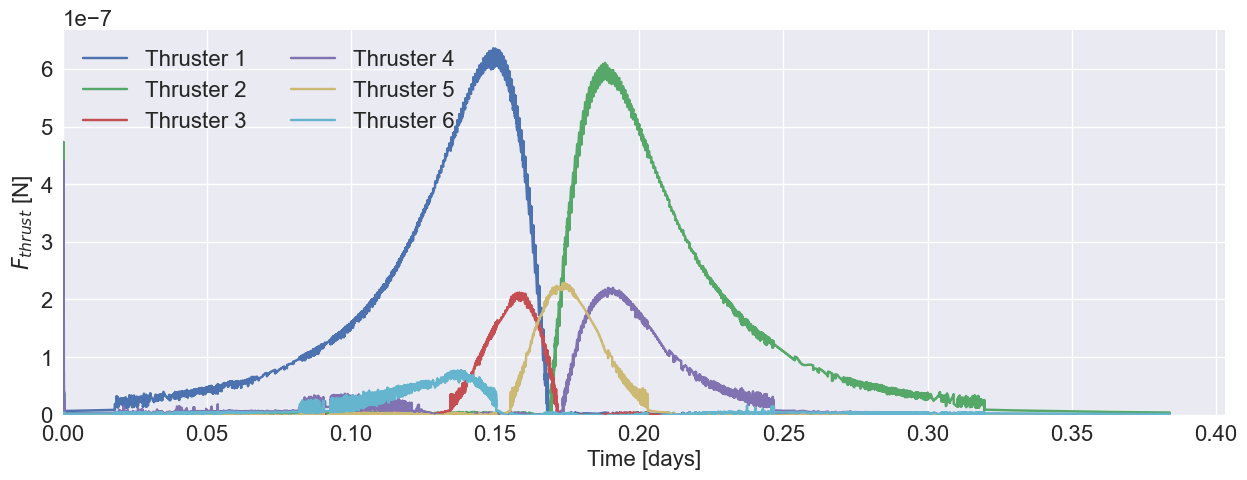

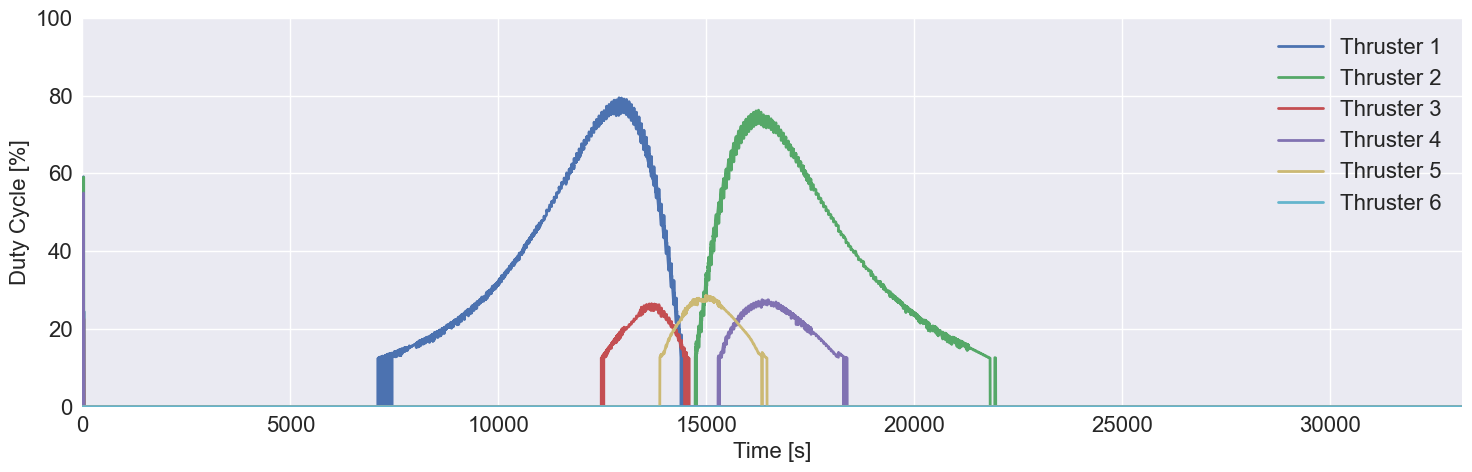

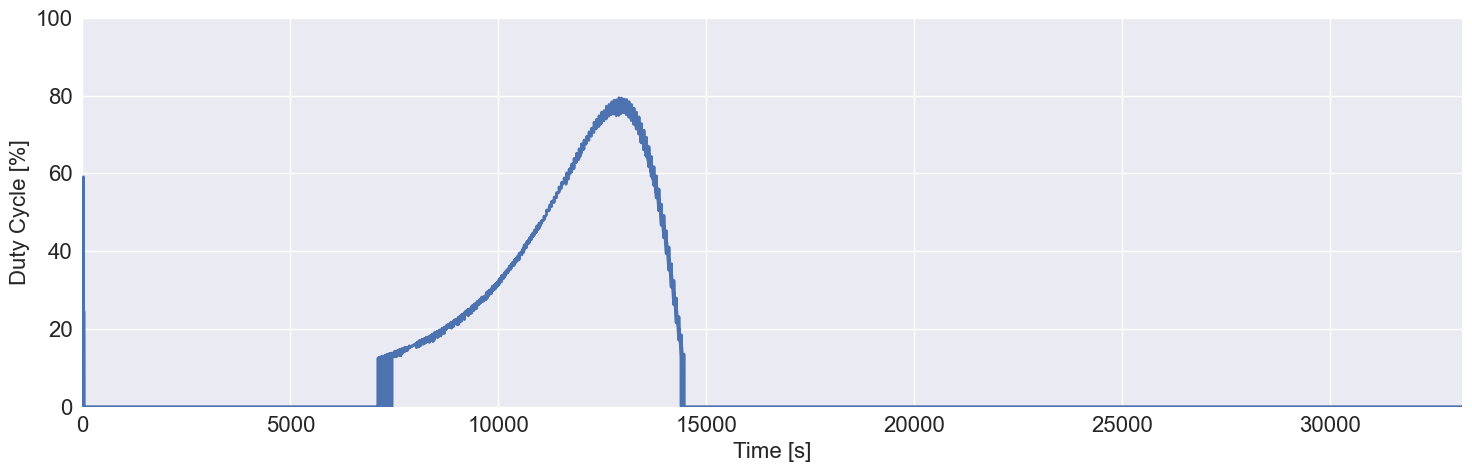

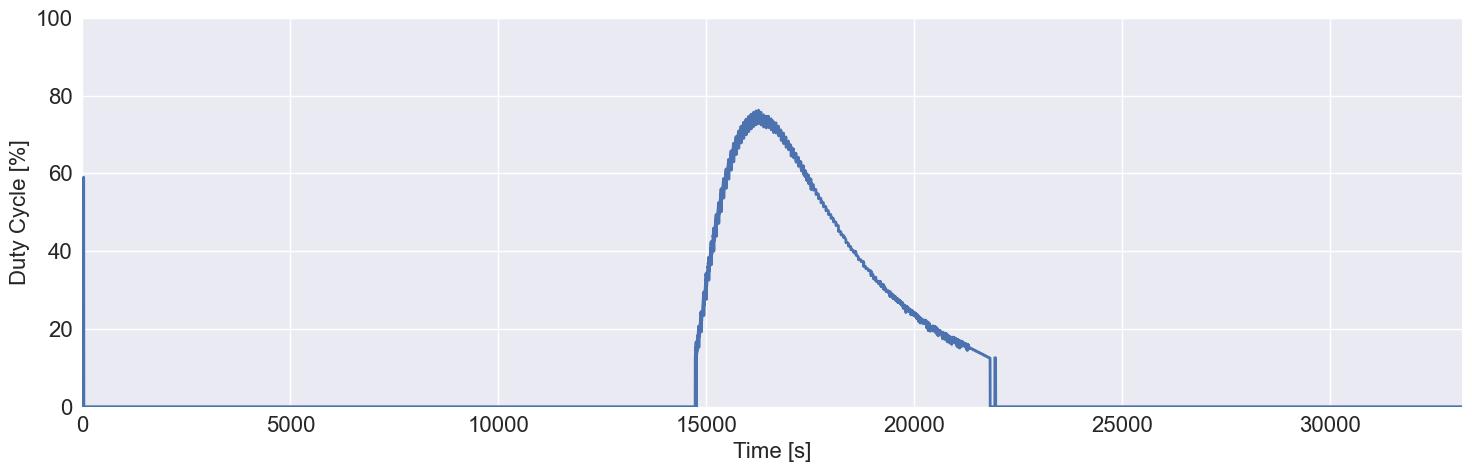

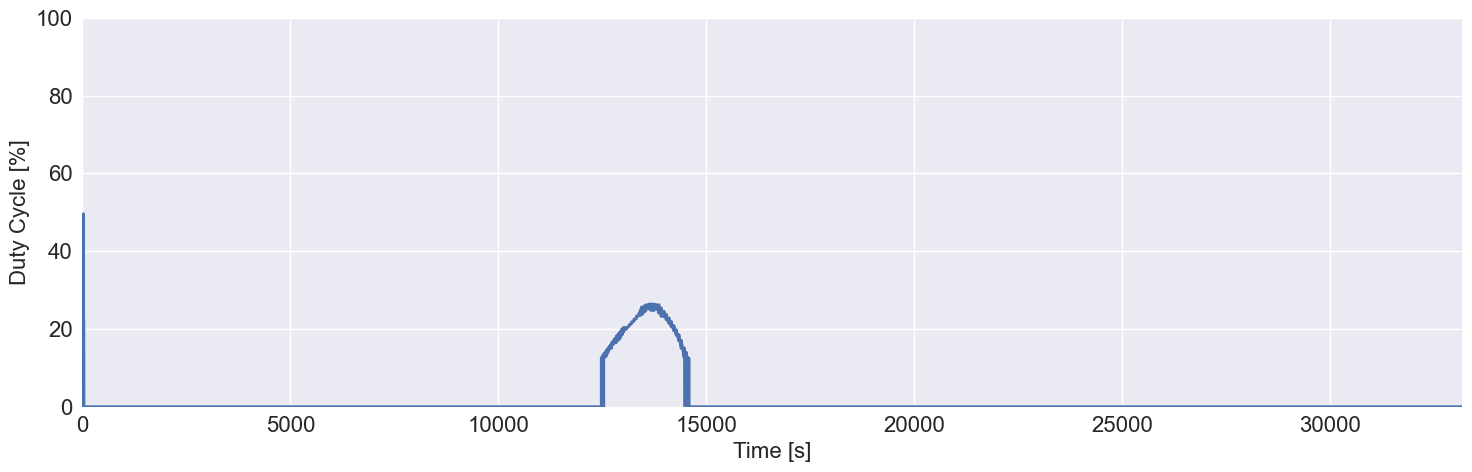

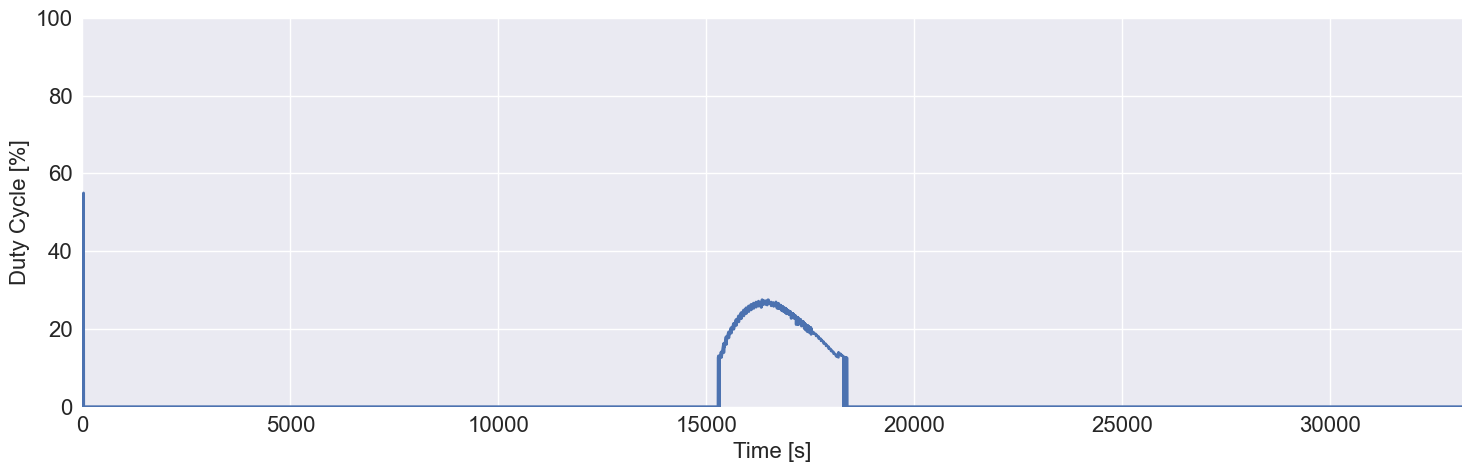

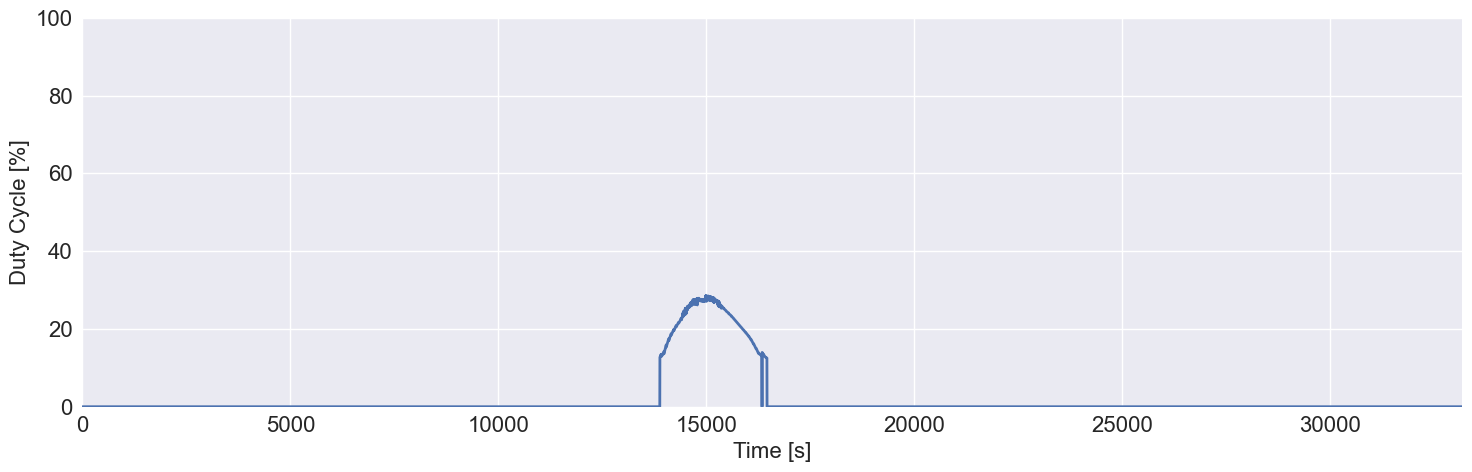

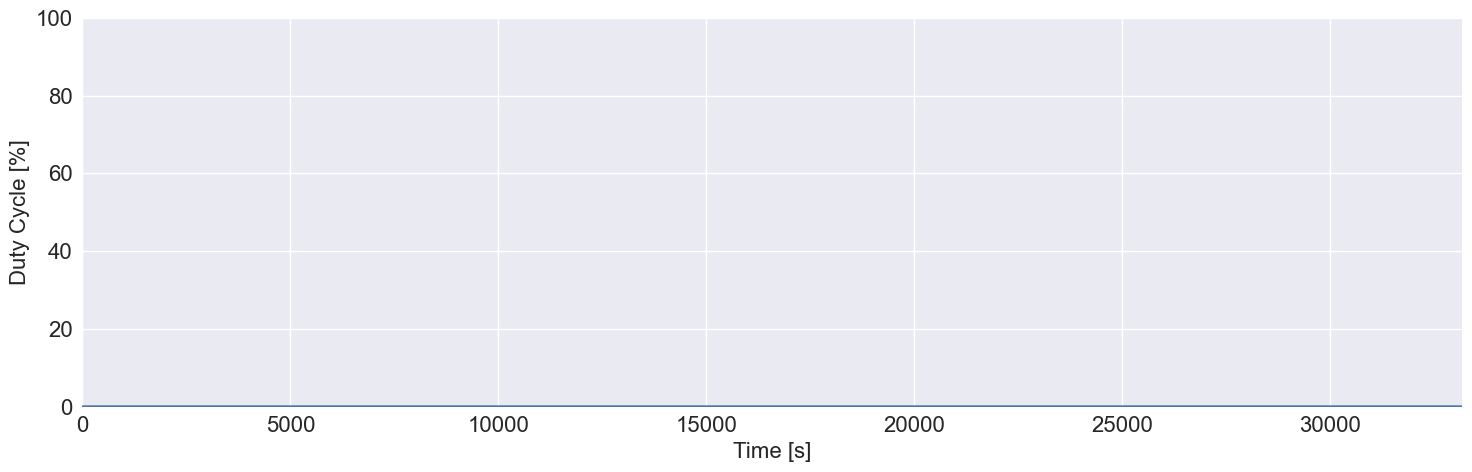

/var/folders/j7/d141j89114bg_cxgrxbrv8_40000gp/T/ipykernel_97362/1420513902.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=16)


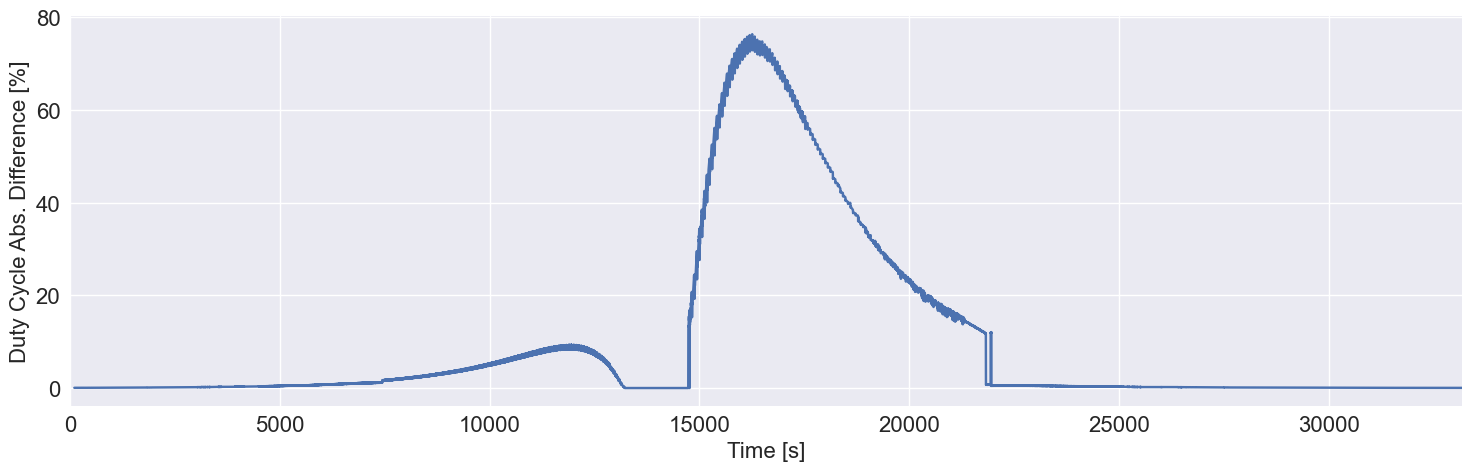

In [199]:
import matplotlib.pyplot as plt
import classes as cl
import numpy as np

duty_cycle = np.loadtxt("results/data/embedded_restofthename_2023-01-05_05-33_2023-01-05_14-46_duty_cycle_vis.dat").T
thrust = np.loadtxt("results/data/embedded_restofthename_2023-01-05_05-33_2023-01-05_14-46_thrust_vis.dat").T
time_array = np.loadtxt("results/data/2023-01-05_05-33_2023-01-05_14-46_time_array_1.dat")

vis = cl.Visualization(time_array)



vis.thrust_values(thrust)

# Apply seaborn style
plt.style.use('seaborn-v0_8')

# Create a single graph with all rows
plt.figure(figsize=(15, 5))

for i in range(6):
    duty_cycle_percentage = (duty_cycle[i] / 100000) * 100  # Convert to percentage
    plt.plot(time_array, duty_cycle_percentage, linewidth=2, label=f"Thruster {i+1}")
# Set axis labels and limits
plt.xlabel("Time [s]", fontsize=16)
plt.ylabel("Duty Cycle [%]", fontsize=16)
plt.ylim(0, 100)  # Duty cycle percentage range
plt.xlim(0, time_array[-1])  # Time range
plt.tick_params(axis='both', which='major', labelsize=16)
# Add legend
plt.legend(fontsize=16)
# Save and show the figure
plt.tight_layout()
plt.show()

# Create six graphs for each row
for i in range(6):
    plt.figure(figsize=(15, 5))  # Adjust size to match other plots
    duty_cycle_percentage = (duty_cycle[i] / 100000) * 100  # Convert to percentage
    plt.plot(time_array, duty_cycle_percentage, linewidth=2)
    
    # Set axis labels and limits
    plt.xlabel("Time [s]", fontsize=16)
    plt.ylabel("Duty Cycle [%]", fontsize=16)
    plt.ylim(0, 100)  # Duty cycle percentage range
    plt.xlim(0, time_array[-1])  # Time range
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    # Apply consistent formatting
    ax = plt.gca()  # Get the current axis
    ax.yaxis.get_offset_text().set_fontsize(16)  # Adjust the font size of scientific notation

    # Save and show the figure
    plt.tight_layout()
    plt.show()


# Apply seaborn style
plt.style.use('seaborn-v0_8')
# Create a single graph with all rows
plt.figure(figsize=(15, 5))
plt.plot(time_array[100:], np.abs((duty_cycle[1,:] / 100000 * 100)[100:] - percentage_thrust_1[100:]))
# Set axis labels and limits
plt.xlabel("Time [s]", fontsize=16)
plt.ylabel("Duty Cycle Abs. Difference [%]", fontsize=16)
plt.xlim(0, time_array[-1])  # Time range
plt.tick_params(axis='both', which='major', labelsize=16)
# Add legend
plt.legend(fontsize=16)
# Save and show the figure
plt.tight_layout()
plt.show()



<!-- ### Simulation - Test block -->

In [ ]:

# Example values (use your actual values here)
q = np.array([0.00397964, 0.00399447, 0.70714173, 0.70704935])
q_ref =  np.array([0.00397964, 0.00399447, 0.70714173, 0.70704935])
omega = np.array([-1.46736360e-08,  9.64721725e-09,  4.04781774e-08])
k_p = np.array([0.0005, 0.0005, 0.0005])
k_i = np.array([0, 0, 0])
k_d = np.array([0.001, 0.001, 0.001])
k_s = np.array([9, 9, 9])
dt = 1.0

print(type(q[0]), type(q_ref), type(omega), type(k_p), type(k_i), type(k_d),type(k_s), type(dt))

pd = cl.PID(cl.Constants.inertia_matrix)

try:
    while True:
        send_parameters(q, q_ref, omega, k_p, k_i, k_d, k_s, dt)
        time.sleep(3)
        line = ser.readline()
        print(line.decode())
        print(pd.control_torque(q, q_ref, omega, k_p, k_i, k_d, k_s, dt))

except KeyboardInterrupt:
    print("Program terminated by user")


### Simulation - MCU connection - 1s and 0s

In [10]:
def simulation_embedded_10(
    data_file_CAPSTONE,
    data_file_Sun,
    omega_0,
    kp,
    kd,
    ks,
    T_matrix
):
    # Load data files
    data_CAPSTONE = np.loadtxt(data_file_CAPSTONE)
    data_Sun = np.loadtxt(data_file_Sun)

    # Create time array based on the input data files and check if they cover the same epochs
    time_array = data_CAPSTONE[:, 0]
    time_array_check = data_Sun[:, 0]
    if time_array.all() != time_array_check.all():
        raise ValueError(
            "Epochs of the data files are not the same; check ephemeris retrieval."
        )
    
    # Empty iteration time array
    it = np.empty((1, len(time_array)))

    # Obtain position data over time
    position_CAPSTONE = data_CAPSTONE[:, 1:4]
    position_Sun = data_Sun[:, 1:4]

    # Retrieve time step from data file
    dt = time_array[1] - time_array[0]

    const = cl.Constants()
    pd = cl.PID(const.inertia_matrix_undeployed)
    dist = cl.DisturbanceTorques(const.inertia_matrix_undeployed)

    # Initialize individual vectors for iteration
    q = pd.reference_quaternion_paper(position_CAPSTONE[0,:], position_Sun[0,:]) # For standard initial position
    omega = omega_0

    # Dummy values for PID
    factor_p = kp
    factor_i = 0
    factor_d = kd
    factor_s = ks

    # Create arrays
    k_p = np.array([1, 1, 1]) * factor_p
    k_i = np.array([1, 1, 1]) * factor_i
    k_d = np.array([1, 1, 1]) * factor_d
    k_s = np.array([1, 1, 1]) * factor_s


    # Index count
    index = 0

    # Initiate angular momentum
    h = 0
    E_RW = 0
    E_thrust = 0

    ser.flushInput()
    ser.write('0'.encode())

    for t in time_array:

        start = time.time()

        # Wait for message
        try:
            message = ser.read().decode().strip()
            if message != "1":
                print("No message received")
                continue
        except serial.SerialException:
            print("Serial port is not properly opened")

        # LUMIO paper-based reference quaternion update
        if index % 1 == 0:
            q_ref = pd.reference_quaternion_paper(position_CAPSTONE[index,:], position_Sun[index,:])

        # Calculate real-time disturbance torques
        T_GG = dist.GGMoon(q, position_CAPSTONE[index, :])
        T_SRP = dist.SRP(position_Sun[index, :], position_CAPSTONE[index, :])
        T_d = T_GG + T_SRP

        # Control torque
        T_c = pd.control_torque(q, q_ref, omega, k_p, k_i, k_d, k_s, dt)

        # Update to t = 1
        # Integrate omega and quaternion
        omega_new = pd.rk4_integrator(pd.derivative_omega, omega, dt, T_d, T_c)
        q_new = pd.rk4_integrator(pd.derivative_quaternion, q, dt, omega)
        q = q_new / np.linalg.norm(q_new)
        omega = omega_new

        # Update index
        index += 1

        try:
            ser.write('0'.encode())
        except Exception as e:
            print(f"An unexpected error occurred: {str(e)}")

        end = time.time()

        it[:,index - 1] = end - start
        
    return np.mean(it)

### RETURN THE MEAN OF THE COMPUTATION TIME OF ONE ITERATION TO COMPARE BASE CASE WITH THE MCU CASE